In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import joblib

In [ ]:
#Load and read the dataset
sdf = pd.read_csv("ebay_stocks_data.csv")
sdf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1998-09-24 00:00:00-04:00,0.938201,0.951354,0.775989,0.830791,0.750675,518656090
1,1998-09-25 00:00:00-04:00,0.797910,0.808870,0.721188,0.786949,0.711061,121255834
2,1998-09-28 00:00:00-04:00,0.832983,0.892168,0.806678,0.846135,0.764539,89772883
3,1998-09-29 00:00:00-04:00,0.865863,0.881208,0.837367,0.857095,0.774443,39289536
4,1998-09-30 00:00:00-04:00,0.827502,0.841751,0.758453,0.790237,0.714032,44113766


### Exploratory Data Analysis

In [3]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6651 entries, 0 to 6650
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6651 non-null   object 
 1   Open       6651 non-null   float64
 2   High       6651 non-null   float64
 3   Low        6651 non-null   float64
 4   Close      6651 non-null   float64
 5   Adj Close  6651 non-null   float64
 6   Volume     6651 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 363.9+ KB


In [ ]:
#Change Date from object to datetime format
sdf["Date"] = pd.to_datetime(sdf["Date"], errors="coerce")
sdf["Date"]

0       1998-09-24 00:00:00-04:00
1       1998-09-25 00:00:00-04:00
2       1998-09-28 00:00:00-04:00
3       1998-09-29 00:00:00-04:00
4       1998-09-30 00:00:00-04:00
                  ...            
6646    2025-02-26 00:00:00-05:00
6647    2025-02-27 00:00:00-05:00
6648    2025-02-28 00:00:00-05:00
6649    2025-03-03 00:00:00-05:00
6650    2025-03-04 00:00:00-05:00
Name: Date, Length: 6651, dtype: object

In [ ]:
#Check missing values

sdf.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

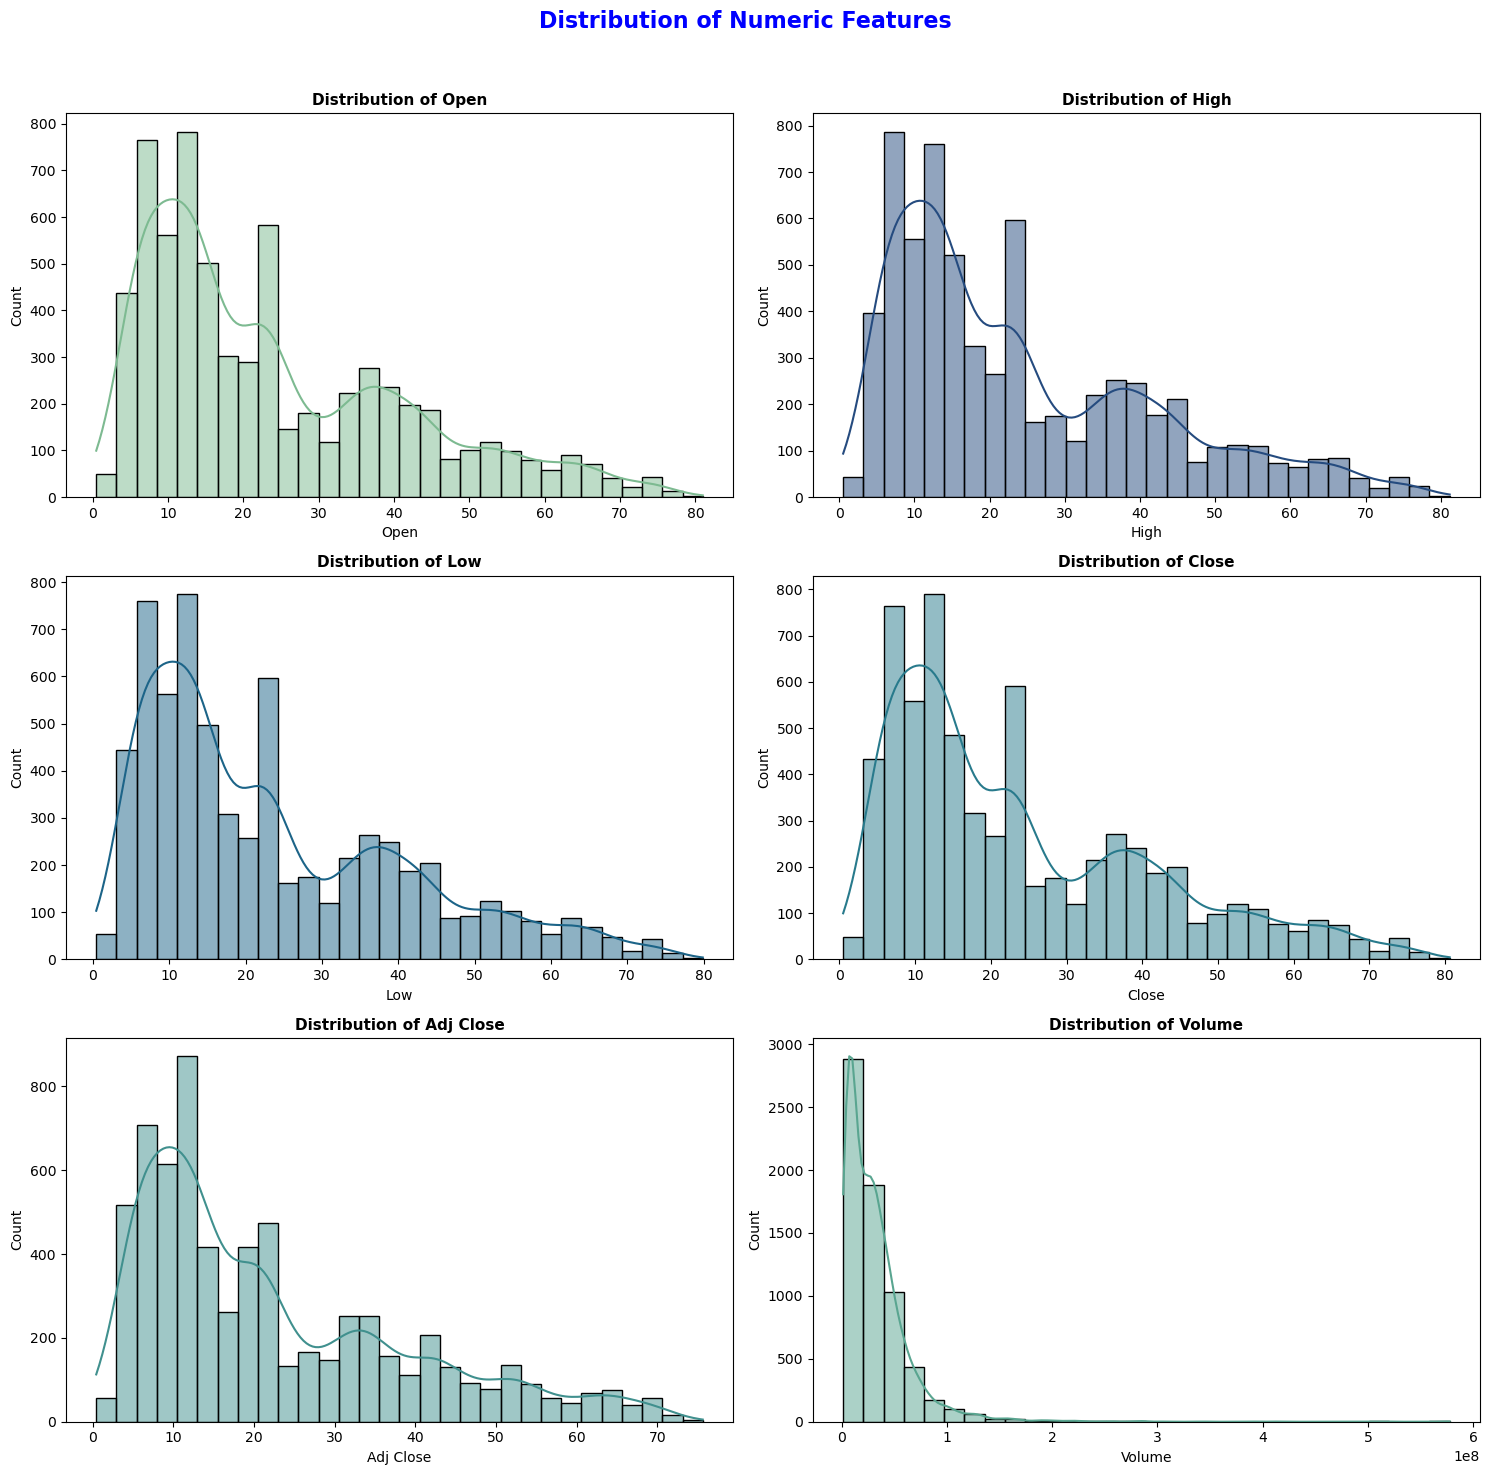

In [ ]:
#Find the distribution of various nuerical features and plot using a histogram
numeric_features = sdf.select_dtypes(include=["int64","float64"])
ncol = numeric_features.columns
palette = sns.color_palette("crest", len(ncol))
plt.figure(figsize=(15,15))

for i, cols in enumerate(ncol,1):
    plt.subplot(3,2,i)
    sns.histplot(sdf[cols], kde=True, bins=30, color=palette[1-i])
    plt.title(f"Distribution of {cols}", fontsize=11, fontweight="bold", color="black")
    plt.tight_layout()
plt.suptitle("Distribution of Numeric Features", fontsize=16, fontweight="bold", color="blue")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()   

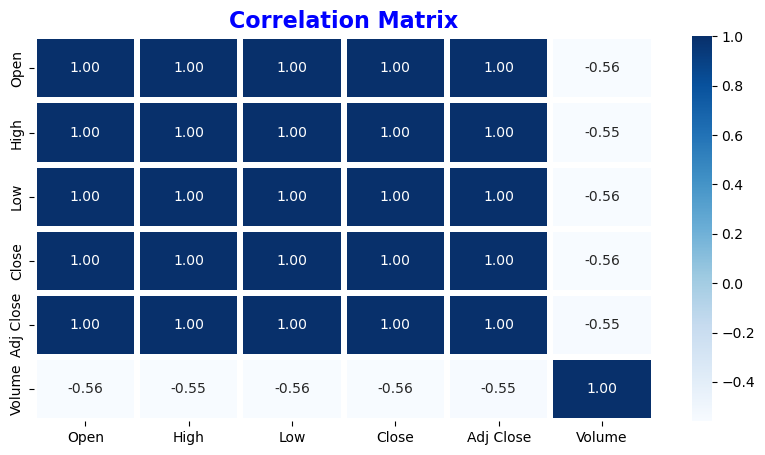

In [ ]:

#Determine the correlation between features 
plt.figure(figsize = (10,5))
sns.heatmap(numeric_features.corr(), annot = True, cmap = "Blues", fmt = ".2f",linewidths=3)
plt.title("Correlation Matrix", fontsize=16, fontweight="bold", color="blue")
plt.show()

### Data Preprocessing & Training

In [ ]:
# Perform feature engineering to create the target variable( The next closing stock price)
sdf["Next_Close"] = sdf["Close"].shift(-1)

#Remove the last row because it has no coresponding next close value
sdf.dropna(subset=["Next_Close"],inplace=True)

In [ ]:
# Spilt data into feature and target variables

X = sdf.drop(columns=["Date","Next_Close"])
y = sdf["Next_Close"]


0.9988863979774174
0.32446901081992857


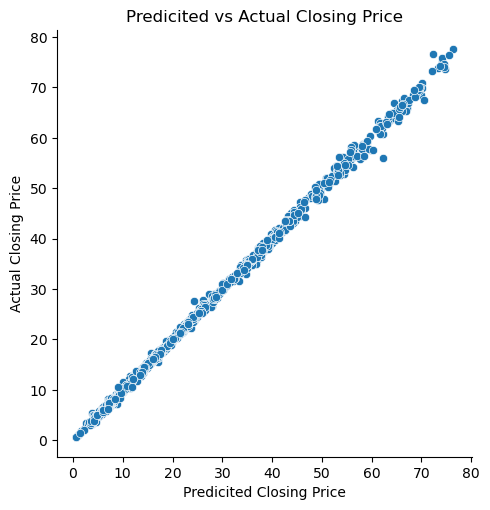

In [ ]:
# Create processing steps to be used in the pipeline
steps = [("scale", StandardScaler()), ("linreg", LinearRegression())]

#Create pipeline
pipe = Pipeline(steps)

#split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

#Use pipelne to scale and train the model
lin_model = pipe.fit(X_train, y_train)

#Make predictions on the test set
y_pred = lin_model.predict(X_test)

#Display metrics for the model and plot the results.
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
sns.relplot(x=y_pred, y=y_test, kind="scatter")
plt.title("Predicited vs Actual Closing Price")
plt.xlabel("Predicited Closing Price")
plt.ylabel("Actual Closing Price")
plt.show()

### Model Evaluation

In [ ]:
#Use Cross Validation to test the variance in the model

kfold = KFold(n_splits=6, shuffle=True, random_state=42)
cv_results = cross_val_score(pipe, X, y, cv=kfold)

#Compute the mean, standard deviation and 95% confidence interval of the 6 folds
cv_mean = np.mean(cv_results)
cv_std = np.std(cv_results)
cv_quantile = np.quantile(cv_results,[0.025,0.975])
print("Model Results: ")
print(f"Mean score - {cv_mean}")
print(f"StandardDeviation - {cv_std}")
print(f"95 percent CI - {cv_quantile}")


Model Results: 
Mean score - 0.9988289578335293
StandardDeviation - 0.00016136034136765586
95 percent CI - [0.99854066 0.99899665]


In [ ]:
#Save the model for later depolymemt.
joblib.dump(pipe,"ebay_stock_linmodel.pkl")

['ebay_stock_linmodel.pkl']